In [2]:
%store -r __toolboxforsalesdata

In [3]:
__toolboxforsalesdata

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
from sklearn.neighbors import NearestNeighbors

In [5]:
train_full = pd.read_csv('train_imputed_unique_0,1_rem_pre_category_mean_no_trim.csv')

In [6]:
test_full_no_knn = pd.read_csv('test_prev_cat_imputed_no_knn.csv')

In [7]:
test_full_with_knn = pd.read_csv('test_prev_cat_imputed_with_knn.csv')

In [8]:
min(test_full_no_knn['item_price'])

4.895752901923296

In [9]:
np.sum(pd.isnull(test_full_no_knn),axis = 0)

Unnamed: 0                      0
ID                              0
shop_id                         0
item_id                         0
item_category_id            15246
indicator                       0
is_music                    15246
lag_shop_item_comb          15246
lag_only_item               15246
lag_only_item_cat           15246
unique                          0
lag2_only_item_cat          15246
lag2_only_item              15246
lag2_shop_item_comb         15246
seasonal_freq_3_feature         0
prev_month_category_mean    15246
item_price                  15246
dtype: int64

In [10]:
15426/len(test_full_no_knn)

0.07201680672268908

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


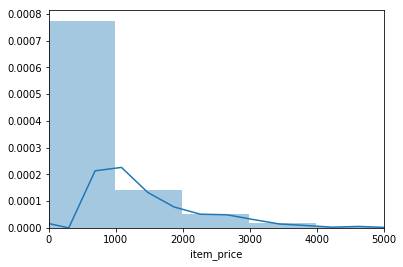

In [11]:
sns.distplot(train_full['item_price'].dropna())
plt.xlim(0,5000)
plt.show()

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


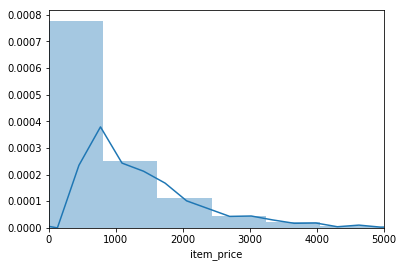

In [12]:
sns.distplot(test_full_no_knn['item_price'].dropna())
plt.xlim(0,5000)
plt.show()

In [13]:
monitoring_data = pd.read_csv('monitoring_data.csv')

In [14]:
monitoring_data.head()

,Unnamed: 0,Model1,Model2,Model3,Model4,Ensemble_Type,Val_Prediction_Name,Test_Prediction_Name,Validation_Type,Validation Set,Validation_Score_before_clip,Validation_Score_after_clip,Public_LB_Score,Features
0,0,xg_model_1_001_subsample_1,lm_model_standardized,rf_n_est_1000_depth_3_sqrt,None,Average,triple_ensemble,trip_ens_submission,Time_based,dropped_col_val33_no_na,22.152129,2.163706,1.17125,Lag1
1,1,xg_model_1_001_subsample_1,lm_model_standardized,rf_n_est_1000_depth_3_sqrt,None,Average,triple_ensemble_sub_025,trip_ens_submission_sub_025,Time_based,dropped_col_val33_no_na,22.152377,2.160372,1.16766,Lag1
2,2,xg_model_1_001_subsample_1,lm_model,None,None,Average,ensemble_lin_xgb,test_ensemble_lin_xgb,Time_based,dropped_col_val33_no_na,20.782377,2.151485,1.14767,Lag1
3,0,xg_model_6_01_subsample_1,lm_model,None,None,alpha(0.092*lm+0.908*xg),ensemble_lin_xgb_0092,ensemble_lin_xgb_0092_lag1_lag2_season,Time_based,subset_of_train_full_lag1_lag2_seasonal,24.935000,2.047780,1.09124,Lag1_Lag2_Seasonal
4,0,xg_model_6_01_subsample_1,lm_model,None,None,alpha(0.092*lm+0.908*xg),ensemble_lin_xgb_0092_less_0025,ensemble_lin_xgb_0092_lag1_lag2_season_less_0025,Time_based,subset_of_train_full_lag1_lag2_seasonal,24.936000,2.050922,1.09067,Lag1_Lag2_Seasonal


In [15]:
def fit_my_knn(df, k):
    for_nn = df['item_id'].copy().drop_duplicates()
    neigh = NearestNeighbors(k)
    neigh.fit(np.expand_dims(for_nn,-1))
    my_neighbors = neigh.kneighbors(np.expand_dims(for_nn,-1))
    nn_dict = {}
    for i in range(k):
        nn_dict['neighbor{}'.format(i+1)] = my_neighbors[1][:,i]
    neighbor_df = pd.DataFrame(nn_dict)
    neighbor_df['item_id'] = for_nn.values
    return neighbor_df

In [16]:
def fill_with_my_neighbors(df_main, neighbor_df, column_names, k_be_considered, merge_need):
    df = df_main.copy()
    if merge_need == True:
        df = df.merge(neighbor_df, on='item_id', how = 'left')
    for col in column_names:
        df.loc[pd.isnull(df['item_category_id']),col] = np.nansum(
            [df[pd.isnull(df['item_category_id'])]['neighbor{}'.format(j+1)].apply(lambda x : df[col][x])/(k_be_considered-1) for j in range(1,k_be_considered)], axis = 0) 
    return df

In [17]:
#Fitting the best model vs current model on train set.

In [18]:
train_full.shape

(1485963, 16)

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


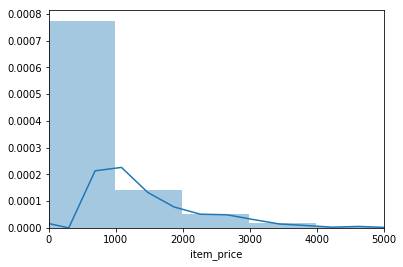

In [19]:
#Removing outliers and high leverage points from train_full.
#from item_price
sns.distplot(train_full['item_price'])
plt.xlim(0,5000)
plt.show()

In [20]:
test_full_with_xnn = test_full_no_knn.copy()

In [21]:
neighbor_df = fit_my_knn(test_full_with_xnn, 5)

In [22]:
test_full_with_knn[test_full_with_knn['item_price']==0].shape

(378, 32)

In [23]:
test_full_with_xnn.columns

Index(['Unnamed: 0', 'ID', 'shop_id', 'item_id', 'item_category_id',
       'indicator', 'is_music', 'lag_shop_item_comb', 'lag_only_item',
       'lag_only_item_cat', 'unique', 'lag2_only_item_cat', 'lag2_only_item',
       'lag2_shop_item_comb', 'seasonal_freq_3_feature',
       'prev_month_category_mean', 'item_price'],
      dtype='object')

In [25]:
#
test_full_with_5nn = fill_with_my_neighbors(test_full_with_xnn, neighbor_df,['is_music', 'lag_shop_item_comb', 'lag_only_item','lag_only_item_cat', 'lag2_only_item_cat', 'lag2_only_item','lag2_shop_item_comb','prev_month_category_mean', 'item_price'],  5, True)







In [26]:
test_full_with_5nn.head()

,Unnamed: 0,ID,shop_id,item_id,item_category_id,indicator,is_music,lag_shop_item_comb,lag_only_item,lag_only_item_cat,...,lag2_only_item,lag2_shop_item_comb,seasonal_freq_3_feature,prev_month_category_mean,item_price,neighbor1,neighbor2,neighbor3,neighbor4,neighbor5
0,0,0,5,5037,19.0,1,False,0.00,25.0,2443.00,...,3.793103,1.00,-0.047512,1.652909,1960.580473,0,2487,1935,5,4828
1,1,1,5,5320,NaN,0,0.5,0.25,10.5,2904.00,...,0.758947,0.75,-0.047512,0.675349,147.724437,1,8,3516,1576,2480
2,2,2,5,5233,19.0,2,False,1.00,42.0,2443.00,...,2.666667,3.00,-0.047512,1.652909,844.516003,2,3,3512,2844,966
3,3,3,5,5232,23.0,1,False,0.00,28.0,2203.00,...,1.846154,0.00,-0.047512,1.651424,792.527697,3,2,3512,2844,966
4,4,4,5,5268,NaN,0,0,0.25,3.5,1634.25,...,0.531250,0.00,-0.047512,1.804027,1115.985824,4,965,2843,3920,4373


/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


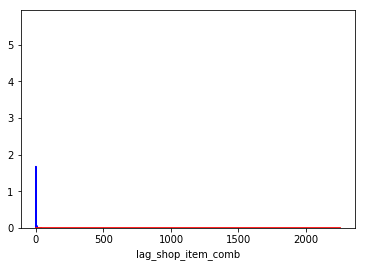

In [27]:
sns.distplot(test_full_with_5nn[pd.isnull(test_full_with_5nn['item_category_id'])]['lag_shop_item_comb'], color='blue')
sns.distplot(test_full_with_5nn[-pd.isnull(test_full_with_5nn['item_category_id'])]['lag_shop_item_comb'] , color = 'red')
plt.show()

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


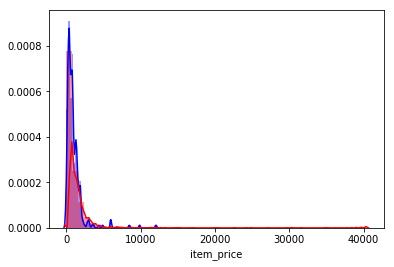

In [28]:
sns.distplot(test_full_with_knn[pd.isnull(test_full_with_5nn['item_category_id'])]['item_price'], color='blue')
sns.distplot(test_full_with_5nn[-pd.isnull(test_full_with_5nn['item_category_id'])]['item_price'] , color = 'red')
plt.show()

In [29]:
min(test_full_no_knn['item_price'])

4.895752901923296

In [30]:
min(test_full_with_5nn['item_price'])

0.0

In [31]:
np.sum(pd.isnull(test_full_no_knn),axis = 0)

Unnamed: 0                      0
ID                              0
shop_id                         0
item_id                         0
item_category_id            15246
indicator                       0
is_music                    15246
lag_shop_item_comb          15246
lag_only_item               15246
lag_only_item_cat           15246
unique                          0
lag2_only_item_cat          15246
lag2_only_item              15246
lag2_shop_item_comb         15246
seasonal_freq_3_feature         0
prev_month_category_mean    15246
item_price                  15246
dtype: int64

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


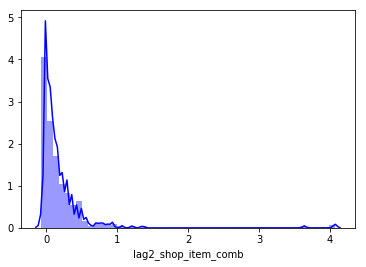

In [32]:
sns.distplot(test_full_with_knn[pd.isnull(test_full_with_5nn['item_category_id'])]['lag2_shop_item_comb'], color='blue')
#sns.distplot(test_full_with_5nn[-pd.isnull(test_full_with_5nn['item_category_id'])]['lag2_shop_item_comb'] , color = 'red')
plt.show()

In [33]:
min(test_full_no_knn['lag2_shop_item_comb'])

-1.0

In [34]:
min(test_full_with_5nn['lag2_shop_item_comb'])

-1.0

In [35]:
#Ok I'll work with this data now.

In [36]:
np.sum(pd.isnull(train_full),axis = 0)

Unnamed: 0                  0
shop_id                     0
item_id                     0
unique                      0
item_price                  0
item_cnt_month              0
item_category_id            0
is_music                    0
lag_shop_item_comb          0
lag_only_item               0
lag_only_item_cat           0
lag2_only_item_cat          0
lag2_shop_item_comb         0
lag2_only_item              0
seasonal_freq_3_feature     0
prev_month_category_mean    0
dtype: int64

In [37]:
np.sum(pd.isnull(test_full_with_5nn),axis = 0)

Unnamed: 0                      0
ID                              0
shop_id                         0
item_id                         0
item_category_id            15246
indicator                       0
is_music                        0
lag_shop_item_comb              0
lag_only_item                   0
lag_only_item_cat               0
unique                          0
lag2_only_item_cat              0
lag2_only_item                  0
lag2_shop_item_comb             0
seasonal_freq_3_feature         0
prev_month_category_mean        0
item_price                      0
neighbor1                       0
neighbor2                       0
neighbor3                       0
neighbor4                       0
neighbor5                       0
dtype: int64

In [38]:
train_full.drop('Unnamed: 0', axis = 1, inplace = True)

In [39]:
test_full_with_5nn.drop('Unnamed: 0', axis = 1, inplace = True)

In [40]:
#Creating lag3 feature.But would need all uniques.

In [41]:
train_temp = pd.read_csv('train_full_lag1_lag2_season.csv')

In [42]:
#By item_category_id
feature_lag3_only_cat = train_temp.groupby(['item_category_id','unique'])['item_cnt_month'].sum().reset_index()

In [43]:
feature_lag3_only_cat['unique'] = feature_lag3_only_cat['unique'] + 3

In [44]:
feature_lag3_only_cat.head()

,item_category_id,unique,item_cnt_month
0,0,3,1.0
1,0,4,1.0
2,0,6,1.0
3,1,3,1.0
4,1,4,1.0


In [45]:
feature_lag3_only_cat.rename(columns={'item_cnt_month':'lag3_only_item_cat'}, inplace = True)

In [46]:
train_full = train_full.merge(feature_lag3_only_cat, on = ['item_category_id','unique'], how = 'left')

In [47]:
#By item_shop_comb
feature_lag3_item_shop = train_temp.groupby(['shop_id','item_id','unique'])['item_cnt_month'].sum().reset_index()

In [48]:
feature_lag3_item_shop['unique'] = feature_lag3_item_shop['unique'] + 3

In [49]:
feature_lag3_item_shop.head()

,shop_id,item_id,unique,item_cnt_month
0,0,30,4,31.0
1,0,31,4,11.0
2,0,32,3,6.0
3,0,32,4,10.0
4,0,33,3,3.0


In [50]:
feature_lag3_item_shop.rename(columns={'item_cnt_month':'lag3_shop_item_comb'}, inplace = True)

In [51]:
train_full = train_full.merge(feature_lag3_item_shop, on = ['shop_id','item_id','unique'], how = 'left')

In [52]:
#By item id only
feature_lag3_only_item = train_temp.groupby(['item_id','unique'])['item_cnt_month'].sum().reset_index()

In [53]:
feature_lag3_only_item['unique'] = feature_lag3_only_item['unique'] + 3

In [54]:
feature_lag3_only_item.head()

,item_id,unique,item_cnt_month
0,0,23,1.0
1,1,18,2.0
2,1,21,1.0
3,1,22,1.0
4,1,23,1.0


In [55]:
feature_lag3_only_item.rename(columns={'item_cnt_month':'lag3_only_item'}, inplace = True)

In [56]:
train_full = train_full.merge(feature_lag3_only_item, on = ['item_id','unique'], how = 'left')

In [57]:
train_full.head()

,shop_id,item_id,unique,item_price,item_cnt_month,item_category_id,is_music,lag_shop_item_comb,lag_only_item,lag_only_item_cat,lag2_only_item_cat,lag2_shop_item_comb,lag2_only_item,seasonal_freq_3_feature,prev_month_category_mean,lag3_only_item_cat,lag3_shop_item_comb,lag3_only_item
0,2,30,2,359.0,1.0,40,False,0.0,861.0,31649.0,1.864851,0.0,0.000000,0.111277,1.971655,NaN,NaN,NaN
1,2,31,2,698.5,1.0,37,False,4.0,628.0,6307.0,1.448538,0.0,0.000000,0.111277,1.619255,NaN,NaN,NaN
2,2,482,2,3300.0,1.0,73,False,1.0,120.0,744.0,2.740891,1.0,3.575758,0.111277,2.940711,NaN,NaN,NaN
3,2,484,2,300.0,2.0,73,False,4.0,200.0,744.0,2.740891,2.0,4.292683,0.111277,2.940711,NaN,NaN,NaN
4,2,687,2,600.0,1.0,73,False,0.0,47.0,744.0,2.740891,0.0,1.952381,0.111277,2.940711,NaN,NaN,NaN


In [58]:
#Removing unique 2 from train_full
train_full = train_full[train_full['unique']!=2]

In [59]:
train_full.head()

,shop_id,item_id,unique,item_price,item_cnt_month,item_category_id,is_music,lag_shop_item_comb,lag_only_item,lag_only_item_cat,lag2_only_item_cat,lag2_shop_item_comb,lag2_only_item,seasonal_freq_3_feature,prev_month_category_mean,lag3_only_item_cat,lag3_shop_item_comb,lag3_only_item
63977,2,31,3,699.0,1.0,37,False,1.0,219.0,6088.0,1.619255,4.0,13.652174,-0.063765,1.578020,6094.0,NaN,NaN
63978,2,464,3,299.0,1.0,49,False,0.0,53.0,1039.0,2.299790,0.0,2.521739,-0.063765,2.107505,939.0,NaN,38.0
63979,2,482,3,3300.0,1.0,73,False,1.0,131.0,764.0,2.940711,1.0,4.137931,-0.063765,2.662021,677.0,1.0,118.0
63980,2,484,3,300.0,3.0,73,False,2.0,130.0,764.0,2.940711,4.0,5.128205,-0.063765,2.662021,677.0,2.0,176.0
63981,2,485,3,300.0,2.0,73,False,0.0,114.0,764.0,2.940711,0.0,0.000000,-0.063765,2.662021,677.0,NaN,NaN


In [60]:
np.sum(pd.isnull(train_full),axis = 0)

shop_id                          0
item_id                          0
unique                           0
item_price                       0
item_cnt_month                   0
item_category_id                 0
is_music                         0
lag_shop_item_comb               0
lag_only_item                    0
lag_only_item_cat                0
lag2_only_item_cat               0
lag2_shop_item_comb              0
lag2_only_item                   0
seasonal_freq_3_feature          0
prev_month_category_mean         0
lag3_only_item_cat            5428
lag3_shop_item_comb         904149
lag3_only_item              336786
dtype: int64

In [61]:
train_full = train_full.fillna(0)

In [62]:
np.sum(pd.isnull(train_full),axis = 0)

shop_id                     0
item_id                     0
unique                      0
item_price                  0
item_cnt_month              0
item_category_id            0
is_music                    0
lag_shop_item_comb          0
lag_only_item               0
lag_only_item_cat           0
lag2_only_item_cat          0
lag2_shop_item_comb         0
lag2_only_item              0
seasonal_freq_3_feature     0
prev_month_category_mean    0
lag3_only_item_cat          0
lag3_shop_item_comb         0
lag3_only_item              0
dtype: int64

In [63]:
#Same features for test.
test_full_with_5nn = test_full_with_5nn.merge(feature_lag3_only_item, on = ['item_id','unique'], how = 'left')
test_full_with_5nn = test_full_with_5nn.merge(feature_lag3_item_shop, on = ['shop_id','item_id','unique'], how = 'left')
test_full_with_5nn = test_full_with_5nn.merge(feature_lag3_only_cat, on = ['item_category_id','unique'], how = 'left')

In [64]:
test_full_with_5nn.head()

,ID,shop_id,item_id,item_category_id,indicator,is_music,lag_shop_item_comb,lag_only_item,lag_only_item_cat,unique,...,prev_month_category_mean,item_price,neighbor1,neighbor2,neighbor3,neighbor4,neighbor5,lag3_only_item,lag3_shop_item_comb,lag3_only_item_cat
0,0,5,5037,19,1,False,0.00,25.0,2443.00,34,...,1.652909,1960.580473,0,2487,1935,5,4828,119.0,3.0,4667.0
1,1,5,5320,NaN,0,0.5,0.25,10.5,2904.00,34,...,0.675349,147.724437,1,8,3516,1576,2480,NaN,NaN,NaN
2,2,5,5233,19,2,False,1.00,42.0,2443.00,34,...,1.652909,844.516003,2,3,3512,2844,966,150.0,1.0,4667.0
3,3,5,5232,23,1,False,0.00,28.0,2203.00,34,...,1.651424,792.527697,3,2,3512,2844,966,65.0,1.0,3650.0
4,4,5,5268,NaN,0,0,0.25,3.5,1634.25,34,...,1.804027,1115.985824,4,965,2843,3920,4373,NaN,NaN,NaN


In [65]:
np.sum(pd.isnull(test_full_with_5nn),axis = 0)

ID                               0
shop_id                          0
item_id                          0
item_category_id             15246
indicator                        0
is_music                         0
lag_shop_item_comb               0
lag_only_item                    0
lag_only_item_cat                0
unique                           0
lag2_only_item_cat               0
lag2_only_item                   0
lag2_shop_item_comb              0
seasonal_freq_3_feature          0
prev_month_category_mean         0
item_price                       0
neighbor1                        0
neighbor2                        0
neighbor3                        0
neighbor4                        0
neighbor5                        0
lag3_only_item               69048
lag3_shop_item_comb         185239
lag3_only_item_cat           15246
dtype: int64

In [66]:
#Filling up test values with 0's first.
test_full_with_5nn[-pd.isnull(test_full_with_5nn['item_category_id'])] = test_full_with_5nn[-pd.isnull(test_full_with_5nn['item_category_id'])].fillna(0)

In [67]:
test_full_with_5nn.head()

,ID,shop_id,item_id,item_category_id,indicator,is_music,lag_shop_item_comb,lag_only_item,lag_only_item_cat,unique,...,prev_month_category_mean,item_price,neighbor1,neighbor2,neighbor3,neighbor4,neighbor5,lag3_only_item,lag3_shop_item_comb,lag3_only_item_cat
0,0,5,5037,19,1,False,0.00,25.0,2443.00,34,...,1.652909,1960.580473,0,2487,1935,5,4828,119.0,3.0,4667.0
1,1,5,5320,NaN,0,0.5,0.25,10.5,2904.00,34,...,0.675349,147.724437,1,8,3516,1576,2480,NaN,NaN,NaN
2,2,5,5233,19,2,False,1.00,42.0,2443.00,34,...,1.652909,844.516003,2,3,3512,2844,966,150.0,1.0,4667.0
3,3,5,5232,23,1,False,0.00,28.0,2203.00,34,...,1.651424,792.527697,3,2,3512,2844,966,65.0,1.0,3650.0
4,4,5,5268,NaN,0,0,0.25,3.5,1634.25,34,...,1.804027,1115.985824,4,965,2843,3920,4373,NaN,NaN,NaN


In [68]:
np.sum(pd.isnull(test_full_with_5nn),axis = 0)

ID                              0
shop_id                         0
item_id                         0
item_category_id            15246
indicator                       0
is_music                        0
lag_shop_item_comb              0
lag_only_item                   0
lag_only_item_cat               0
unique                          0
lag2_only_item_cat              0
lag2_only_item                  0
lag2_shop_item_comb             0
seasonal_freq_3_feature         0
prev_month_category_mean        0
item_price                      0
neighbor1                       0
neighbor2                       0
neighbor3                       0
neighbor4                       0
neighbor5                       0
lag3_only_item              15246
lag3_shop_item_comb         15246
lag3_only_item_cat          15246
dtype: int64

In [69]:
#Yup now the knn filling.
test_full_with_5nn = fill_with_my_neighbors(test_full_with_5nn, neighbor_df,['lag3_shop_item_comb', 'lag3_only_item','lag3_only_item_cat'],  5, False)


In [70]:
np.sum(pd.isnull(test_full_with_5nn),axis = 0)

ID                              0
shop_id                         0
item_id                         0
item_category_id            15246
indicator                       0
is_music                        0
lag_shop_item_comb              0
lag_only_item                   0
lag_only_item_cat               0
unique                          0
lag2_only_item_cat              0
lag2_only_item                  0
lag2_shop_item_comb             0
seasonal_freq_3_feature         0
prev_month_category_mean        0
item_price                      0
neighbor1                       0
neighbor2                       0
neighbor3                       0
neighbor4                       0
neighbor5                       0
lag3_only_item                  0
lag3_shop_item_comb             0
lag3_only_item_cat              0
dtype: int64

In [71]:
train_full.columns

Index(['shop_id', 'item_id', 'unique', 'item_price', 'item_cnt_month',
       'item_category_id', 'is_music', 'lag_shop_item_comb', 'lag_only_item',
       'lag_only_item_cat', 'lag2_only_item_cat', 'lag2_shop_item_comb',
       'lag2_only_item', 'seasonal_freq_3_feature', 'prev_month_category_mean',
       'lag3_only_item_cat', 'lag3_shop_item_comb', 'lag3_only_item'],
      dtype='object')

In [72]:
train33 , val33 = month_split(train_full,33)

In [78]:
xg_train_full = xgboost.DMatrix(train_full.drop(['shop_id','item_id','item_category_id','item_cnt_month','unique'], axis = 1), label=train_full['item_cnt_month'])

In [79]:
xg_train_cv = xgboost.DMatrix(train33.drop(['shop_id','item_id','item_category_id','item_cnt_month','unique'], axis = 1), label=train33['item_cnt_month'])

In [80]:
xg_val_cv  = xgboost.DMatrix(val33.drop(['shop_id','item_id','item_category_id','item_cnt_month','unique'], axis = 1), label=val33['item_cnt_month'])

In [81]:
param_1 = {'max_depth': 6, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'subsample' : 1,'eval_metric': 'rmse'}

In [249]:
progress1 = {}
xgb_model_1 = xgboost.train(param_1, xg_train_cv,early_stopping_rounds=30,evals = [(xg_train_cv , "train_set"),(xg_val_cv,"validation_set")], evals_result=progress1
                                         ,num_boost_round=1000)

[0]	train_set-rmse:9.04107	validation_set-rmse:14.6079
Multiple eval metrics have been passed: 'validation_set-rmse' will be used for early stopping.

Will train until validation_set-rmse hasn't improved in 30 rounds.
[1]	train_set-rmse:8.98641	validation_set-rmse:14.5765
[2]	train_set-rmse:8.93256	validation_set-rmse:14.5469
[3]	train_set-rmse:8.87934	validation_set-rmse:14.5164
[4]	train_set-rmse:8.82688	validation_set-rmse:14.4877
[5]	train_set-rmse:8.77501	validation_set-rmse:14.4581
[6]	train_set-rmse:8.72386	validation_set-rmse:14.4309
[7]	train_set-rmse:8.6731	validation_set-rmse:14.4025
[8]	train_set-rmse:8.62322	validation_set-rmse:14.3768
[9]	train_set-rmse:8.57399	validation_set-rmse:14.3503
[10]	train_set-rmse:8.52543	validation_set-rmse:14.3243
[11]	train_set-rmse:8.47752	validation_set-rmse:14.2998
[12]	train_set-rmse:8.43024	validation_set-rmse:14.2729
[13]	train_set-rmse:8.38346	validation_set-rmse:14.2487
[14]	train_set-rmse:8.33749	validation_set-rmse:14.2243
[15]	tra

[144]	train_set-rmse:5.46962	validation_set-rmse:12.5535
[145]	train_set-rmse:5.46123	validation_set-rmse:12.5387
[146]	train_set-rmse:5.45344	validation_set-rmse:12.5267
[147]	train_set-rmse:5.44568	validation_set-rmse:12.5208
[148]	train_set-rmse:5.43766	validation_set-rmse:12.5061
[149]	train_set-rmse:5.43019	validation_set-rmse:12.4944
[150]	train_set-rmse:5.42219	validation_set-rmse:12.4797
[151]	train_set-rmse:5.41478	validation_set-rmse:12.4683
[152]	train_set-rmse:5.40729	validation_set-rmse:12.4626
[153]	train_set-rmse:5.4	validation_set-rmse:12.4482
[154]	train_set-rmse:5.39311	validation_set-rmse:12.4369
[155]	train_set-rmse:5.38593	validation_set-rmse:12.4314
[156]	train_set-rmse:5.3777	validation_set-rmse:12.4209
[157]	train_set-rmse:5.37131	validation_set-rmse:12.4099
[158]	train_set-rmse:5.36459	validation_set-rmse:12.4045
[159]	train_set-rmse:5.35817	validation_set-rmse:12.3936
[160]	train_set-rmse:5.35137	validation_set-rmse:12.3799
[161]	train_set-rmse:5.34456	validat

[289]	train_set-rmse:4.86266	validation_set-rmse:11.9313
[290]	train_set-rmse:4.86073	validation_set-rmse:11.9315
[291]	train_set-rmse:4.85867	validation_set-rmse:11.932
[292]	train_set-rmse:4.85562	validation_set-rmse:11.9318
[293]	train_set-rmse:4.85425	validation_set-rmse:11.9336
[294]	train_set-rmse:4.85163	validation_set-rmse:11.9332
[295]	train_set-rmse:4.84968	validation_set-rmse:11.933
[296]	train_set-rmse:4.84716	validation_set-rmse:11.9326
[297]	train_set-rmse:4.84531	validation_set-rmse:11.9332
[298]	train_set-rmse:4.84377	validation_set-rmse:11.9292
[299]	train_set-rmse:4.84189	validation_set-rmse:11.9298
[300]	train_set-rmse:4.84028	validation_set-rmse:11.9303
[301]	train_set-rmse:4.83725	validation_set-rmse:11.9301
[302]	train_set-rmse:4.83553	validation_set-rmse:11.9321
[303]	train_set-rmse:4.8342	validation_set-rmse:11.9318
[304]	train_set-rmse:4.83132	validation_set-rmse:11.9304
[305]	train_set-rmse:4.83008	validation_set-rmse:11.9302
[306]	train_set-rmse:4.82724	valid

[434]	train_set-rmse:4.67182	validation_set-rmse:11.8084
[435]	train_set-rmse:4.67093	validation_set-rmse:11.8084
[436]	train_set-rmse:4.67028	validation_set-rmse:11.8075
[437]	train_set-rmse:4.66974	validation_set-rmse:11.8072
[438]	train_set-rmse:4.66924	validation_set-rmse:11.8071
[439]	train_set-rmse:4.6687	validation_set-rmse:11.8068
[440]	train_set-rmse:4.66816	validation_set-rmse:11.8064
[441]	train_set-rmse:4.6674	validation_set-rmse:11.8071
[442]	train_set-rmse:4.66665	validation_set-rmse:11.8073
[443]	train_set-rmse:4.66616	validation_set-rmse:11.807
[444]	train_set-rmse:4.66565	validation_set-rmse:11.8067
[445]	train_set-rmse:4.66514	validation_set-rmse:11.8065
[446]	train_set-rmse:4.66466	validation_set-rmse:11.8065
[447]	train_set-rmse:4.66402	validation_set-rmse:11.8065
[448]	train_set-rmse:4.66203	validation_set-rmse:11.8064
[449]	train_set-rmse:4.66142	validation_set-rmse:11.8056
[450]	train_set-rmse:4.66071	validation_set-rmse:11.8056
[451]	train_set-rmse:4.6602	valida

[579]	train_set-rmse:4.54971	validation_set-rmse:11.7772
[580]	train_set-rmse:4.54927	validation_set-rmse:11.7773
[581]	train_set-rmse:4.54877	validation_set-rmse:11.7771
[582]	train_set-rmse:4.54761	validation_set-rmse:11.7772
[583]	train_set-rmse:4.54718	validation_set-rmse:11.7773
[584]	train_set-rmse:4.54678	validation_set-rmse:11.7766
[585]	train_set-rmse:4.54622	validation_set-rmse:11.7763
[586]	train_set-rmse:4.54585	validation_set-rmse:11.776
[587]	train_set-rmse:4.54488	validation_set-rmse:11.7755
[588]	train_set-rmse:4.54364	validation_set-rmse:11.7757
[589]	train_set-rmse:4.5431	validation_set-rmse:11.7754
[590]	train_set-rmse:4.54293	validation_set-rmse:11.7753
[591]	train_set-rmse:4.54244	validation_set-rmse:11.7753
[592]	train_set-rmse:4.54132	validation_set-rmse:11.7753
[593]	train_set-rmse:4.54095	validation_set-rmse:11.7751
[594]	train_set-rmse:4.54054	validation_set-rmse:11.7752
[595]	train_set-rmse:4.54042	validation_set-rmse:11.7752
[596]	train_set-rmse:4.54001	vali

[724]	train_set-rmse:4.40122	validation_set-rmse:11.7627
[725]	train_set-rmse:4.40072	validation_set-rmse:11.7628
[726]	train_set-rmse:4.40052	validation_set-rmse:11.7628
Stopping. Best iteration:
[696]	train_set-rmse:4.42477	validation_set-rmse:11.7599



In [73]:
for_plot = pd.DataFrame([(v, k) for k, v in xgb_model_1.get_fscore().items()])
plt.figure()
for_plot.sort_values(0,inplace=True)
sns.barplot(x = for_plot[1], y =for_plot[0])
plt.xticks(rotation = 90)
plt.show()

NameError: name 'xgb_model_1' is not defined

In [253]:
param_2 = {'max_depth': 1, 'eta': 0.01, 'silent': 1, 'objective': 'reg:linear', 'subsample' : 1,'eval_metric': 'rmse'}

In [254]:
progress2 = {}
xgb_model_2 = xgboost.train(param_2, xg_train_cv,early_stopping_rounds=30,evals = [(xg_train_cv , "train_set"),(xg_val_cv,"validation_set")], evals_result=progress1
                                         ,num_boost_round=1000)

[0]	train_set-rmse:9.06623	validation_set-rmse:14.6241
Multiple eval metrics have been passed: 'validation_set-rmse' will be used for early stopping.

Will train until validation_set-rmse hasn't improved in 30 rounds.
[1]	train_set-rmse:9.03651	validation_set-rmse:14.61
[2]	train_set-rmse:9.00729	validation_set-rmse:14.5962
[3]	train_set-rmse:8.97855	validation_set-rmse:14.5826
[4]	train_set-rmse:8.95029	validation_set-rmse:14.5694
[5]	train_set-rmse:8.92249	validation_set-rmse:14.5563
[6]	train_set-rmse:8.89516	validation_set-rmse:14.5437
[7]	train_set-rmse:8.86829	validation_set-rmse:14.5311
[8]	train_set-rmse:8.84186	validation_set-rmse:14.5189
[9]	train_set-rmse:8.81588	validation_set-rmse:14.5067
[10]	train_set-rmse:8.79033	validation_set-rmse:14.495
[11]	train_set-rmse:8.76521	validation_set-rmse:14.4833
[12]	train_set-rmse:8.74052	validation_set-rmse:14.4719
[13]	train_set-rmse:8.71625	validation_set-rmse:14.4607
[14]	train_set-rmse:8.69227	validation_set-rmse:14.4394
[15]	train

[144]	train_set-rmse:7.00408	validation_set-rmse:13.3249
[145]	train_set-rmse:6.99777	validation_set-rmse:13.3194
[146]	train_set-rmse:6.99155	validation_set-rmse:13.3169
[147]	train_set-rmse:6.98537	validation_set-rmse:13.3117
[148]	train_set-rmse:6.97927	validation_set-rmse:13.31
[149]	train_set-rmse:6.97322	validation_set-rmse:13.3047
[150]	train_set-rmse:6.96722	validation_set-rmse:13.304
[151]	train_set-rmse:6.96129	validation_set-rmse:13.2965
[152]	train_set-rmse:6.95542	validation_set-rmse:13.2919
[153]	train_set-rmse:6.94957	validation_set-rmse:13.2912
[154]	train_set-rmse:6.9438	validation_set-rmse:13.2888
[155]	train_set-rmse:6.93806	validation_set-rmse:13.2836
[156]	train_set-rmse:6.93242	validation_set-rmse:13.2791
[157]	train_set-rmse:6.92681	validation_set-rmse:13.2784
[158]	train_set-rmse:6.92126	validation_set-rmse:13.2778
[159]	train_set-rmse:6.91573	validation_set-rmse:13.2734
[160]	train_set-rmse:6.91029	validation_set-rmse:13.2728
[161]	train_set-rmse:6.90488	valida

[289]	train_set-rmse:6.46916	validation_set-rmse:13.0339
[290]	train_set-rmse:6.46702	validation_set-rmse:13.0339
[291]	train_set-rmse:6.4649	validation_set-rmse:13.033
[292]	train_set-rmse:6.46279	validation_set-rmse:13.0317
[293]	train_set-rmse:6.46069	validation_set-rmse:13.0317
[294]	train_set-rmse:6.45861	validation_set-rmse:13.0309
[295]	train_set-rmse:6.45653	validation_set-rmse:13.0292
[296]	train_set-rmse:6.45447	validation_set-rmse:13.025
[297]	train_set-rmse:6.45243	validation_set-rmse:13.025
[298]	train_set-rmse:6.45039	validation_set-rmse:13.0242
[299]	train_set-rmse:6.44837	validation_set-rmse:13.0236
[300]	train_set-rmse:6.44636	validation_set-rmse:13.0236
[301]	train_set-rmse:6.44437	validation_set-rmse:13.0229
[302]	train_set-rmse:6.44238	validation_set-rmse:13.0209
[303]	train_set-rmse:6.4404	validation_set-rmse:13.0209
[304]	train_set-rmse:6.43844	validation_set-rmse:13.02
[305]	train_set-rmse:6.43649	validation_set-rmse:13.017
[306]	train_set-rmse:6.43457	validation

[434]	train_set-rmse:6.26043	validation_set-rmse:12.9199
[435]	train_set-rmse:6.25951	validation_set-rmse:12.9197
[436]	train_set-rmse:6.25859	validation_set-rmse:12.9193
[437]	train_set-rmse:6.25768	validation_set-rmse:12.9193
[438]	train_set-rmse:6.25677	validation_set-rmse:12.9187
[439]	train_set-rmse:6.25588	validation_set-rmse:12.9187
[440]	train_set-rmse:6.25498	validation_set-rmse:12.9168
[441]	train_set-rmse:6.25409	validation_set-rmse:12.9165
[442]	train_set-rmse:6.2532	validation_set-rmse:12.9153
[443]	train_set-rmse:6.25232	validation_set-rmse:12.9153
[444]	train_set-rmse:6.25145	validation_set-rmse:12.915
[445]	train_set-rmse:6.25058	validation_set-rmse:12.915
[446]	train_set-rmse:6.24971	validation_set-rmse:12.9145
[447]	train_set-rmse:6.24885	validation_set-rmse:12.9145
[448]	train_set-rmse:6.24799	validation_set-rmse:12.9142
[449]	train_set-rmse:6.24714	validation_set-rmse:12.9124
[450]	train_set-rmse:6.24629	validation_set-rmse:12.9124
[451]	train_set-rmse:6.24545	valid

[579]	train_set-rmse:6.16718	validation_set-rmse:12.8619
[580]	train_set-rmse:6.16673	validation_set-rmse:12.8606
[581]	train_set-rmse:6.16629	validation_set-rmse:12.8605
[582]	train_set-rmse:6.16585	validation_set-rmse:12.8605
[583]	train_set-rmse:6.16542	validation_set-rmse:12.8592
[584]	train_set-rmse:6.16498	validation_set-rmse:12.859
[585]	train_set-rmse:6.16454	validation_set-rmse:12.8588
[586]	train_set-rmse:6.16411	validation_set-rmse:12.8589
[587]	train_set-rmse:6.16368	validation_set-rmse:12.8585
[588]	train_set-rmse:6.16325	validation_set-rmse:12.8584
[589]	train_set-rmse:6.16282	validation_set-rmse:12.8582
[590]	train_set-rmse:6.16239	validation_set-rmse:12.858
[591]	train_set-rmse:6.16197	validation_set-rmse:12.858
[592]	train_set-rmse:6.16154	validation_set-rmse:12.8576
[593]	train_set-rmse:6.16112	validation_set-rmse:12.8576
[594]	train_set-rmse:6.1607	validation_set-rmse:12.8574
[595]	train_set-rmse:6.16028	validation_set-rmse:12.8573
[596]	train_set-rmse:6.15986	valida

[724]	train_set-rmse:6.11629	validation_set-rmse:12.8292
[725]	train_set-rmse:6.11601	validation_set-rmse:12.8282
[726]	train_set-rmse:6.11574	validation_set-rmse:12.8282
[727]	train_set-rmse:6.11547	validation_set-rmse:12.8281
[728]	train_set-rmse:6.1152	validation_set-rmse:12.828
[729]	train_set-rmse:6.11492	validation_set-rmse:12.8279
[730]	train_set-rmse:6.11465	validation_set-rmse:12.8279
[731]	train_set-rmse:6.11438	validation_set-rmse:12.8279
[732]	train_set-rmse:6.11411	validation_set-rmse:12.8278
[733]	train_set-rmse:6.11385	validation_set-rmse:12.8277
[734]	train_set-rmse:6.11358	validation_set-rmse:12.8273
[735]	train_set-rmse:6.11331	validation_set-rmse:12.8273
[736]	train_set-rmse:6.11304	validation_set-rmse:12.8263
[737]	train_set-rmse:6.11278	validation_set-rmse:12.8262
[738]	train_set-rmse:6.11251	validation_set-rmse:12.8262
[739]	train_set-rmse:6.11225	validation_set-rmse:12.8261
[740]	train_set-rmse:6.11198	validation_set-rmse:12.826
[741]	train_set-rmse:6.11172	valid

[869]	train_set-rmse:6.08166	validation_set-rmse:12.8168
[870]	train_set-rmse:6.08145	validation_set-rmse:12.8168
[871]	train_set-rmse:6.08124	validation_set-rmse:12.8167
[872]	train_set-rmse:6.08103	validation_set-rmse:12.816
[873]	train_set-rmse:6.08082	validation_set-rmse:12.816
[874]	train_set-rmse:6.08061	validation_set-rmse:12.816
[875]	train_set-rmse:6.0804	validation_set-rmse:12.816
[876]	train_set-rmse:6.08019	validation_set-rmse:12.8159
[877]	train_set-rmse:6.07999	validation_set-rmse:12.8159
[878]	train_set-rmse:6.07978	validation_set-rmse:12.8159
[879]	train_set-rmse:6.07957	validation_set-rmse:12.8158
[880]	train_set-rmse:6.07936	validation_set-rmse:12.8155
[881]	train_set-rmse:6.07916	validation_set-rmse:12.8155
[882]	train_set-rmse:6.07895	validation_set-rmse:12.8155
[883]	train_set-rmse:6.07874	validation_set-rmse:12.8155
[884]	train_set-rmse:6.07854	validation_set-rmse:12.8155
[885]	train_set-rmse:6.07833	validation_set-rmse:12.8155
[886]	train_set-rmse:6.07813	validat

In [99]:
#Fitting xgb model to whole train set.
xgb_model_1_full = xgboost.train(param_1, xg_train_full,early_stopping_rounds=30,evals = [(xg_train_full , "train_set")]
                                         ,num_boost_round=696)

[0]	train_set-rmse:9.19989
Will train until train_set-rmse hasn't improved in 30 rounds.
[1]	train_set-rmse:9.14518
[2]	train_set-rmse:9.09123
[3]	train_set-rmse:9.03793
[4]	train_set-rmse:8.98528
[5]	train_set-rmse:8.93338
[6]	train_set-rmse:8.88209
[7]	train_set-rmse:8.83144
[8]	train_set-rmse:8.78142
[9]	train_set-rmse:8.7318
[10]	train_set-rmse:8.68307
[11]	train_set-rmse:8.63471
[12]	train_set-rmse:8.58707
[13]	train_set-rmse:8.54017
[14]	train_set-rmse:8.49389
[15]	train_set-rmse:8.44804
[16]	train_set-rmse:8.40265
[17]	train_set-rmse:8.35782
[18]	train_set-rmse:8.31392
[19]	train_set-rmse:8.27027
[20]	train_set-rmse:8.22723
[21]	train_set-rmse:8.18471
[22]	train_set-rmse:8.14302
[23]	train_set-rmse:8.10084
[24]	train_set-rmse:8.06014
[25]	train_set-rmse:8.01884
[26]	train_set-rmse:7.97931
[27]	train_set-rmse:7.93905
[28]	train_set-rmse:7.8994
[29]	train_set-rmse:7.86106
[30]	train_set-rmse:7.82209
[31]	train_set-rmse:7.78373
[32]	train_set-rmse:7.74614
[33]	train_set-rmse:7.7092

[286]	train_set-rmse:4.88638
[287]	train_set-rmse:4.88413
[288]	train_set-rmse:4.88176
[289]	train_set-rmse:4.87955
[290]	train_set-rmse:4.87751
[291]	train_set-rmse:4.87381
[292]	train_set-rmse:4.87184
[293]	train_set-rmse:4.87003
[294]	train_set-rmse:4.86673
[295]	train_set-rmse:4.86481
[296]	train_set-rmse:4.86276
[297]	train_set-rmse:4.86059
[298]	train_set-rmse:4.85872
[299]	train_set-rmse:4.85548
[300]	train_set-rmse:4.85361
[301]	train_set-rmse:4.85171
[302]	train_set-rmse:4.84994
[303]	train_set-rmse:4.84838
[304]	train_set-rmse:4.84663
[305]	train_set-rmse:4.84481
[306]	train_set-rmse:4.84291
[307]	train_set-rmse:4.84106
[308]	train_set-rmse:4.83959
[309]	train_set-rmse:4.83777
[310]	train_set-rmse:4.83612
[311]	train_set-rmse:4.8335
[312]	train_set-rmse:4.83151
[313]	train_set-rmse:4.83008
[314]	train_set-rmse:4.82853
[315]	train_set-rmse:4.82493
[316]	train_set-rmse:4.82291
[317]	train_set-rmse:4.82107
[318]	train_set-rmse:4.81754
[319]	train_set-rmse:4.81608
[320]	train_set

[570]	train_set-rmse:4.53048
[571]	train_set-rmse:4.5297
[572]	train_set-rmse:4.52951
[573]	train_set-rmse:4.52875
[574]	train_set-rmse:4.52829
[575]	train_set-rmse:4.52434
[576]	train_set-rmse:4.52185
[577]	train_set-rmse:4.52102
[578]	train_set-rmse:4.52032
[579]	train_set-rmse:4.51715
[580]	train_set-rmse:4.51578
[581]	train_set-rmse:4.51478
[582]	train_set-rmse:4.5131
[583]	train_set-rmse:4.51257
[584]	train_set-rmse:4.51159
[585]	train_set-rmse:4.51151
[586]	train_set-rmse:4.51104
[587]	train_set-rmse:4.50898
[588]	train_set-rmse:4.50802
[589]	train_set-rmse:4.50425
[590]	train_set-rmse:4.50378
[591]	train_set-rmse:4.5031
[592]	train_set-rmse:4.50189
[593]	train_set-rmse:4.50117
[594]	train_set-rmse:4.49744
[595]	train_set-rmse:4.49543
[596]	train_set-rmse:4.49498
[597]	train_set-rmse:4.49405
[598]	train_set-rmse:4.49359
[599]	train_set-rmse:4.49243
[600]	train_set-rmse:4.49173
[601]	train_set-rmse:4.48879
[602]	train_set-rmse:4.48686
[603]	train_set-rmse:4.48596
[604]	train_set-r

In [82]:
lm_model_1 = LinearRegression().fit(train33.drop(['shop_id','item_id','item_category_id','item_cnt_month','unique'], axis = 1), train33['item_cnt_month'])

In [83]:
lm_model_1_full = LinearRegression().fit(train_full.drop(['shop_id','item_id','item_category_id','item_cnt_month','unique'], axis = 1), train_full['item_cnt_month'])

In [84]:
lm_model_1_full.score(train_full.drop(['shop_id','item_id','item_category_id','item_cnt_month','unique'], axis = 1), train_full['item_cnt_month'])

0.4955254659371564

In [85]:
test_for_pred = test_full_with_5nn[train_full.drop('item_cnt_month',axis = 1).columns]

In [86]:
test_for_pred['is_music'] = test_for_pred['is_music'].astype(np.float)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [87]:
test_for_pred.loc[test_for_pred['is_music']>0.5,'is_music'] = 1
test_for_pred.loc[test_for_pred['is_music']<0.5,'is_music'] = 0

/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [88]:
xg_test_set = xgboost.DMatrix(test_for_pred.drop(['shop_id','item_id','item_category_id','unique'], axis = 1))

In [89]:
xg_prediction = xgb_model_1_full.predict(xg_test_set)

NameError: name 'xgb_model_1_full' is not defined

In [90]:
len(np.unique(xg_prediction))

NameError: name 'xg_prediction' is not defined

In [91]:
lin_prediction = lm_model_1_full.predict(test_for_pred.drop(['shop_id','item_id','item_category_id','unique'], axis = 1))

In [92]:
len(np.unique(lin_prediction))

35382

In [281]:
from tqdm import tqdm

In [282]:
#First finding best alpha for ensembling on val set. alpha*lin + (1-alpha)*xgb
alphas = np.arange(0,1,0.001)
best_alpha = 0
for_xg = xgb_model_1.predict(xg_val_cv,ntree_limit=696)
for_lm = lm_model_1.predict(val33.drop(['shop_id','item_id','item_category_id','item_cnt_month','unique'], axis = 1))
best_error = compute_trimmed_rmse(for_xg.copy(),val33['item_cnt_month'].copy())
for alpha in tqdm(alphas):
    temp_pred = alpha*for_lm + (1-alpha)*for_xg
    temp_error = compute_trimmed_rmse(temp_pred.copy() , val33['item_cnt_month'].copy())
    if (temp_error < best_error):
        best_alpha= alpha
        best_error = temp_error

100%|██████████| 1000/1000 [00:11<00:00, 85.54it/s]


In [283]:
best_alpha

0.101

In [284]:
best_error

2.094761558118785

In [285]:
monitoring_data

,Unnamed: 0,Model1,Model2,Model3,Model4,Ensemble_Type,Val_Prediction_Name,Test_Prediction_Name,Validation_Type,Validation Set,Validation_Score_before_clip,Validation_Score_after_clip,Public_LB_Score,Features
0,0,xg_model_1_001_subsample_1,lm_model_standardized,rf_n_est_1000_depth_3_sqrt,None,Average,triple_ensemble,trip_ens_submission,Time_based,dropped_col_val33_no_na,22.152129,2.163706,1.17125,Lag1
1,1,xg_model_1_001_subsample_1,lm_model_standardized,rf_n_est_1000_depth_3_sqrt,None,Average,triple_ensemble_sub_025,trip_ens_submission_sub_025,Time_based,dropped_col_val33_no_na,22.152377,2.160372,1.16766,Lag1
2,2,xg_model_1_001_subsample_1,lm_model,None,None,Average,ensemble_lin_xgb,test_ensemble_lin_xgb,Time_based,dropped_col_val33_no_na,20.782377,2.151485,1.14767,Lag1
3,0,xg_model_6_01_subsample_1,lm_model,None,None,alpha(0.092*lm+0.908*xg),ensemble_lin_xgb_0092,ensemble_lin_xgb_0092_lag1_lag2_season,Time_based,subset_of_train_full_lag1_lag2_seasonal,24.935000,2.047780,1.09124,Lag1_Lag2_Seasonal
4,0,xg_model_6_01_subsample_1,lm_model,None,None,alpha(0.092*lm+0.908*xg),ensemble_lin_xgb_0092_less_0025,ensemble_lin_xgb_0092_lag1_lag2_season_less_0025,Time_based,subset_of_train_full_lag1_lag2_seasonal,24.936000,2.050922,1.09067,Lag1_Lag2_Seasonal


In [287]:
submit_pred = 0.101 * lin_prediction + (1-0.101) * xg_prediction

In [288]:
len(np.unique(submit_pred))

35381

In [289]:
submission = pd.DataFrame({'ID':test_full_with_5nn['ID'],'item_cnt_month':submit_pred})

In [290]:
submission.head()

,ID,item_cnt_month
0,0,1.703203
1,1,1.688846
2,2,1.760960
3,3,1.685943
4,4,1.725092


In [291]:
submission.loc[submission['item_cnt_month'] > 20, 'item_cnt_month'] = 20
submission.loc[submission['item_cnt_month'] < 0, 'item_cnt_month'] = 0

In [292]:
submission.head()

,ID,item_cnt_month
0,0,1.703203
1,1,1.688846
2,2,1.760960
3,3,1.685943
4,4,1.725092


In [317]:
less_it = submission['item_cnt_month']-2

In [323]:
less_it[less_it < 0] = 0

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


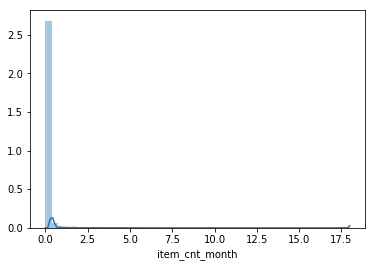

In [349]:
sns.distplot(less_it)
plt.show()

In [294]:
check = pd.read_csv('train_full_lag1_lag2_season.csv')

In [296]:
np.mean(check['item_cnt_month'])

2.26720161678232

In [297]:
len(submission)

214200

In [76]:
check_pred = pd.read_csv('ensemble_lin_xgb_0092_lag1_lag2_season.csv')

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


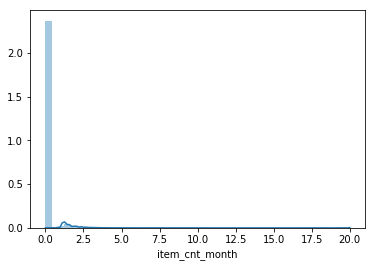

In [348]:
sns.distplot(check_pred['item_cnt_month'])
plt.show()

In [327]:
rmse(less_it,check_pred['item_cnt_month'])

1.071206480551722

In [328]:
submission_less_2 = submission.copy()

In [329]:
submission_less_2['item_cnt_month'] = less_it

In [330]:
submission_less_2.to_csv('submission_less_2_lag3.csv',index=False)

In [331]:
sum(submission_less_2['item_cnt_month'] == 0)/len(submission_less_2)

0.7690476190476191

In [332]:
max(submission['item_cnt_month'])

20.0

In [333]:
submission.to_csv('submission_lag3.csv',index=False)

In [ ]:
submit_pred = 0.101 * lin_prediction + (1-0.101) * xg_prediction

In [336]:
#FUll lin but not full xg, insanity I know.
pred_insane = 0.101 * lin_prediction + (1-0.101) * xgb_model_1.predict(xg_test_set,ntree_limit=696)

In [337]:
pred_insane

array([1.6280903 , 1.10351593, 1.62563832, ..., 1.0977909 , 1.10247579,
       1.12654862])

In [341]:
submit_insane = pd.DataFrame({'ID':test_full_with_5nn['ID'],'item_cnt_month':pred_insane})

In [344]:
submit_insane.loc[submit_insane['item_cnt_month'] > 20, 'item_cnt_month'] = 20
submit_insane.loc[submit_insane['item_cnt_month'] < 0, 'item_cnt_month'] = 0

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


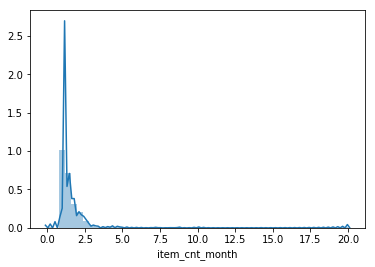

In [345]:
sns.distplot(submit_insane['item_cnt_month'])
plt.show()

In [354]:
sum(check_pred['item_cnt_month']==0)/len(check_pred)

0.9467366946778711

In [355]:
sum(less_it == 0)/len(less_it)

0.7690476190476191

In [362]:
less_it_further = less_it - 0.2

In [363]:
less_it_further[less_it_further<0] = 0

In [364]:
sum(less_it_further == 0)/len(less_it)

0.9280345471521942

In [365]:
submission_less_2_2 = submission_less_2.copy()

In [366]:
submission_less_2_2['item_cnt_month'] = less_it_further

In [368]:
submission_less_2_2.to_csv('submission_less_2_2.csv', index=False)

In [74]:
submission_less_2_2 = pd.read_csv('submission_less_2_2.csv')

In [105]:
submission = pd.read_csv('submission_lag3.csv')

In [77]:
rmse(check_pred['item_cnt_month'], submission_less_2_2['item_cnt_month'])

1.063152889591256

In [93]:
submit_only_lin = pd.DataFrame({'ID':test_full_with_5nn['ID'],'item_cnt_month':lin_prediction})

In [97]:
submit_only_lin.loc[submit_only_lin['item_cnt_month'] > 20, 'item_cnt_month'] = 20
submit_only_lin.loc[submit_only_lin['item_cnt_month'] < 0, 'item_cnt_month'] = 0

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


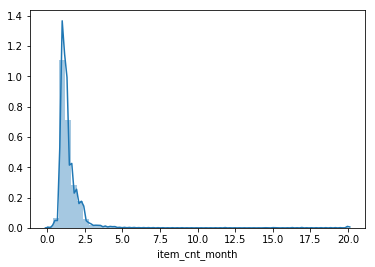

In [98]:
sns.distplot(submit_only_lin['item_cnt_month'])

In [100]:
need_to_learn = pd.read_csv('xg_boost4_cats.csv')

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


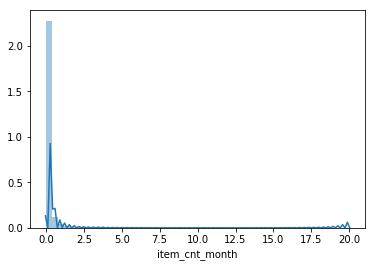

In [104]:
sns.distplot(need_to_learn['item_cnt_month'])
plt.show()

In [106]:
np.mean(need_to_learn['item_cnt_month'])

0.2934720535420514

In [107]:
np.mean(submission['item_cnt_month'])

1.9281114344776054

In [110]:
rmse(need_to_learn['item_cnt_month'], submission['item_cnt_month'])

1.9394134241858443

In [111]:
test_full_with_5nn.head()

,ID,shop_id,item_id,item_category_id,indicator,is_music,lag_shop_item_comb,lag_only_item,lag_only_item_cat,unique,...,prev_month_category_mean,item_price,neighbor1,neighbor2,neighbor3,neighbor4,neighbor5,lag3_only_item,lag3_shop_item_comb,lag3_only_item_cat
0,0,5,5037,19,1,False,0.00,25.0,2443.00,34,...,1.652909,1960.580473,0,2487,1935,5,4828,119.00,3.0,4667.00
1,1,5,5320,NaN,0,0.5,0.25,10.5,2904.00,34,...,0.675349,147.724437,1,8,3516,1576,2480,19.75,1.0,3011.00
2,2,5,5233,19,2,False,1.00,42.0,2443.00,34,...,1.652909,844.516003,2,3,3512,2844,966,150.00,1.0,4667.00
3,3,5,5232,23,1,False,0.00,28.0,2203.00,34,...,1.651424,792.527697,3,2,3512,2844,966,65.00,1.0,3650.00
4,4,5,5268,NaN,0,0,0.25,3.5,1634.25,34,...,1.804027,1115.985824,4,965,2843,3920,4373,6.50,0.0,2510.25


In [112]:
bb = pd.read_csv('bad_baseline_no4.csv')

In [113]:
bb

,ID,item_cnt_month
0,0,0.242641
1,1,0.242641
2,2,0.242641
3,3,0.242641
4,4,0.242641
5,5,0.242641
6,6,0.242641
7,7,0.242641
8,8,0.242641
9,9,0.242641


In [114]:
??rmse

In [116]:
submission_less_2_2.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.089063
std,61834.358168,1.041037
min,0.000000,0.000000
25%,53549.750000,0.000000
50%,107099.500000,0.000000
75%,160649.250000,0.000000
max,214199.000000,17.800000


In [118]:
stacked = pd.read_csv('ver6_lr_stacking.csv')

In [119]:
stacked.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.298604
std,61834.358168,0.760702
min,0.000000,0.000000
25%,53549.750000,0.044390
50%,107099.500000,0.116017
75%,160649.250000,0.274164
max,214199.000000,20.000000


In [120]:
need_to_learn.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.293472
std,61834.358168,0.686291
min,0.000000,0.000000
25%,53549.750000,0.138123
50%,107099.500000,0.177906
75%,160649.250000,0.279623
max,214199.000000,20.000000


In [125]:
train_full.head()

,shop_id,item_id,unique,item_price,item_cnt_month,item_category_id,is_music,lag_shop_item_comb,lag_only_item,lag_only_item_cat,lag2_only_item_cat,lag2_shop_item_comb,lag2_only_item,seasonal_freq_3_feature,prev_month_category_mean,lag3_only_item_cat,lag3_shop_item_comb,lag3_only_item
63977,2,31,3,699.0,1.0,37,False,1.0,219.0,6088.0,1.619255,4.0,13.652174,-0.063765,1.578020,6094.0,0.0,0.0
63978,2,464,3,299.0,1.0,49,False,0.0,53.0,1039.0,2.299790,0.0,2.521739,-0.063765,2.107505,939.0,0.0,38.0
63979,2,482,3,3300.0,1.0,73,False,1.0,131.0,764.0,2.940711,1.0,4.137931,-0.063765,2.662021,677.0,1.0,118.0
63980,2,484,3,300.0,3.0,73,False,2.0,130.0,764.0,2.940711,4.0,5.128205,-0.063765,2.662021,677.0,2.0,176.0
63981,2,485,3,300.0,2.0,73,False,0.0,114.0,764.0,2.940711,0.0,0.000000,-0.063765,2.662021,677.0,0.0,0.0


In [126]:
item_cats = pd.read_csv('item_categories.csv')

In [127]:
item_cats

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [128]:
train_full.head()

,shop_id,item_id,unique,item_price,item_cnt_month,item_category_id,is_music,lag_shop_item_comb,lag_only_item,lag_only_item_cat,lag2_only_item_cat,lag2_shop_item_comb,lag2_only_item,seasonal_freq_3_feature,prev_month_category_mean,lag3_only_item_cat,lag3_shop_item_comb,lag3_only_item
63977,2,31,3,699.0,1.0,37,False,1.0,219.0,6088.0,1.619255,4.0,13.652174,-0.063765,1.578020,6094.0,0.0,0.0
63978,2,464,3,299.0,1.0,49,False,0.0,53.0,1039.0,2.299790,0.0,2.521739,-0.063765,2.107505,939.0,0.0,38.0
63979,2,482,3,3300.0,1.0,73,False,1.0,131.0,764.0,2.940711,1.0,4.137931,-0.063765,2.662021,677.0,1.0,118.0
63980,2,484,3,300.0,3.0,73,False,2.0,130.0,764.0,2.940711,4.0,5.128205,-0.063765,2.662021,677.0,2.0,176.0
63981,2,485,3,300.0,2.0,73,False,0.0,114.0,764.0,2.940711,0.0,0.000000,-0.063765,2.662021,677.0,0.0,0.0


In [129]:
train_full.to_csv('train_full_lag_1_2_3_imputed_rem_unique_0_1_2.csv', index = False)

In [130]:
test_full_with_5nn.to_csv('test_lag1_lag2_lag3_imputed_5_neigh.csv', index = False)